In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import networkx as nx
import matplotlib.pyplot as plt

import gc
import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from sklearn.covariance import empirical_covariance
from latentcor import latentcor

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Load data and preprocess
- Load all four species with their high abundance gene set and subsample to only rRNA genes
- Filter out cells containing no information
- Converting genes to protein clusters (PCs) as index
- Assemble for each species pd.df such that all have same dimesions as input for gglasso

In [2]:
ec_mudata = md.read("../data/preprocessed/preprocessed_new/preprocessed/ec_mudata_preprocessed.h5mu")
ec_gc5 = ec_mudata["gc5_genes"].copy()
ec_gc5 = ec_gc5[:, ~ec_gc5.var["rRNA"]].copy()
sc.pp.filter_cells(ec_gc5, min_counts=1)
ec_gc5

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


AnnData object with n_obs × n_vars = 2405 × 24
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [3]:
efm_mudata = md.read("../data/preprocessed/preprocessed_new/preprocessed/efm_mudata_preprocessed.h5mu")
efm_gc5 = efm_mudata["gc5_genes"].copy()
efm_gc5 = efm_gc5[:, ~efm_gc5.var["rRNA"]].copy()
sc.pp.filter_cells(efm_gc5, min_counts=1)
efm_gc5

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


AnnData object with n_obs × n_vars = 4657 × 33
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [4]:
psa_mudata = md.read("../data/preprocessed/preprocessed_new/preprocessed/psa_mudata_preprocessed.h5mu")
psa_gc5 = psa_mudata["gc5_genes"].copy()
psa_gc5 = psa_gc5[:, ~psa_gc5.var["rRNA"]].copy()
sc.pp.filter_cells(psa_gc5, min_counts=1)
psa_gc5

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


AnnData object with n_obs × n_vars = 172 × 19
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [5]:
kp_mudata = md.read("../data/preprocessed/preprocessed_new/preprocessed/kp_mudata_preprocessed.h5mu")
kp_gc5 = kp_mudata["gc5_genes"].copy()
kp_gc5 = kp_gc5[:, ~kp_gc5.var["rRNA"]].copy()
sc.pp.filter_cells(kp_gc5, min_counts=1)
kp_gc5

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


AnnData object with n_obs × n_vars = 646 × 18
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [6]:
path_nSBM = '../data/data/mudata_nSBM_hierarchy_2_final_4_species.h5mu'
data_nSBM = md.read_h5mu(path_nSBM)
data_nSBM

MuData object with n_obs × n_vars = 36469 × 33412
  3 modalities
    SC_genes:	36469 x 14009
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	36469 x 13687
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	36469 x 5716
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

Taking the lev6 (most aggregated and connected) protein clusters and translate genes of each strain into cluster \
Note, in adata its obs x var; now we transpose for gglasso

In [7]:
data_nSBM["SC_proteins"].varm["protein_hierarchy"]

,lev0,lev1,lev2,lev3,lev4,lev5,lev6,lev_root
NP_052605.1,lev00totlen16795,forDFlev16795,forDFlev26795,forDFlev36795,forDFlev46795,forDFlev56795,forDFlev66795,root
NP_052606.1,lev00totlen17549,forDFlev17549,forDFlev27549,forDFlev37549,forDFlev47549,forDFlev57549,forDFlev67549,root
NP_052608.1,lev00totlen15594,forDFlev15594,forDFlev25594,forDFlev35594,forDFlev45594,forDFlev55594,forDFlev65594,root
NP_052609.1,lev00totlen12063,forDFlev12063,forDFlev22063,forDFlev32063,forDFlev42063,forDFlev52063,forDFlev62063,root
NP_052610.1,lev00totlen1576,forDFlev1576,forDFlev2576,forDFlev3576,forDFlev4576,forDFlev5576,forDFlev6576,root
...,...,...,...,...,...,...,...,...
WP_004152553.1,lev00totlen14198,forDFlev14198,forDFlev24198,forDFlev34198,forDFlev44198,forDFlev54198,forDFlev64198,root
WP_004178188.1,lev00totlen11303,forDFlev11303,forDFlev21303,forDFlev31303,forDFlev41303,forDFlev51303,forDFlev61303,root
WP_228131004.1,lev00totlen11253,forDFlev11253,forDFlev21253,forDFlev31253,forDFlev41253,forDFlev51253,forDFlev61253,root
WP_228131000.1,lev020totlen21057,forDFlev11057,forDFlev21057,forDFlev31057,forDFlev41057,forDFlev51057,forDFlev61057,root


In [8]:
intersection_genes = set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[ec_gc5.var["protein"]]["lev6"].values).intersection(
    set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[efm_gc5.var["protein"]]["lev6"].values),
    set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[psa_gc5.var["protein"]]["lev6"].values),
    set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[kp_gc5.var["protein"]]["lev6"].values))
intersection_genes

{'forDFlev6183',
 'forDFlev62429',
 'forDFlev63405',
 'forDFlev6348',
 'forDFlev6543',
 'forDFlev6943'}

In [27]:
strains_dict = {"ec": ec_gc5, "efm": efm_gc5, "psa": psa_gc5, "kp": kp_gc5}
S = dict()
all_obs = dict()
N = 150

idx = 0
for name, adata in strains_dict.items():

    print(f"Strain: {name}")
    obs = pd.DataFrame(index=data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[adata.var["protein"]]["lev6"].values,
                      data=adata.layers["sqrt_counts"].T.A)
    #downsample to N cells
    obs_sample = obs.sample(n=N, axis=1)
    #only take genes present in all strains
    obs_sample = obs_sample.loc[obs_sample.index.isin(intersection_genes)]
    #aggregate ProtClusters
    obs_sample = obs_sample.groupby(obs_sample.index).sum()
    #calc latent correlations with latentcor
    tps = ["tru"] * obs_sample.shape[0]
    latent = latentcor(obs_sample.T, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=False)
    
    all_obs[idx] = pd.DataFrame(index=obs_sample.index,
                                columns=range(N),
                                data=obs_sample.values)
    S[idx] = latent["R"].to_numpy()
    idx += 1 
print(len(S), len(all_obs))
print(S[0].shape)
print(all_obs[0].shape)

Strain: ec
Strain: efm
Strain: psa
Strain: kp
4 4
(6, 6)
(6, 150)


/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


In [28]:
all_obs[0]

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
forDFlev6183,0.0,1.0,1.414214,0.0,2.000000,1.732051,0.0,4.828427,0.000000,1.414214,...,1.414214,1.0,0.0,1.0,2.0,1.000000,1.732051,0.0,0.0,0.0
forDFlev62429,1.0,0.0,1.000000,0.0,0.000000,0.000000,0.0,2.236068,1.732051,0.000000,...,0.000000,0.0,0.0,1.0,0.0,1.414214,1.000000,1.0,0.0,1.0
forDFlev63405,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,1.0,0.0,0.000000,1.000000,0.0,0.0,0.0
forDFlev6348,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.414214,0.000000,0.000000,...,1.414214,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0
forDFlev6543,0.0,0.0,1.000000,0.0,1.414214,1.000000,1.0,0.000000,0.000000,0.000000,...,1.414214,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
forDFlev6943,1.0,0.0,1.414214,0.0,0.000000,1.414214,0.0,1.000000,0.000000,0.000000,...,0.000000,0.0,1.0,0.0,0.0,0.000000,1.000000,0.0,1.0,0.0


In [29]:
S[0]

array([[ 1.        ,  0.40822329, -0.01751956,  0.18200965,  0.00822491,
         0.09623039],
       [ 0.40822329,  1.        ,  0.03534707,  0.11969221, -0.06642244,
         0.3456417 ],
       [-0.01751956,  0.03534707,  1.        ,  0.11874971, -0.04726484,
         0.18393601],
       [ 0.18200965,  0.11969221,  0.11874971,  1.        ,  0.18261319,
         0.3810573 ],
       [ 0.00822491, -0.06642244, -0.04726484,  0.18261319,  1.        ,
         0.07116411],
       [ 0.09623039,  0.3456417 ,  0.18393601,  0.3810573 ,  0.07116411,
         1.        ]])

### GGLASSO

In [14]:
from gglasso.helper.ext_admm_helper import create_group_array, construct_indexer, check_G

In [30]:
ix_exist, ix_location = construct_indexer(list(all_obs.values()))

In [31]:
G = create_group_array(ix_exist, ix_location, min_inst=4)

Creation of bookeeping array...
10% finished
20% finished
30% finished
40% finished
50% finished
60% finished
70% finished
80% finished
90% finished


In [32]:
check_G(G, 6)

In [33]:
from gglasso.problem import glasso_problem

In [34]:
for k in range(4):
    assert S[k].shape[0] == S[k].shape[1], f"Dimensions are not correct, 1st and 2nd dimension have to match but do not match for instance {k}."
    assert np.max(np.abs(S[k] - S[k].T)) <= 0.1, f"Covariance data for instance {k} is not symmetric."

In [35]:
P = glasso_problem(S=S, N=N, reg="GGL", reg_params=None, latent=True, G=G, do_scaling=True)
print(P)

 
GROUP GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': None, 'lambda2': None, 'mu1': None}


/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/gglasso/problem.py:257: UserWarning: NOTE: Input data S is rescaled to correlations, this has impact on the scale of the regularization parameters!
  warnings.warn("NOTE: Input data S is rescaled to correlations, this has impact on the scale of the regularization parameters!")
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/gglasso/problem.py:258: UserWarning: The output/solution is rescaled to covariances. All model selection output, in particular the optimal regularization parameters in self.reg_params are corresponding to the correlations.
  warnings.warn("The output/solution is rescaled to covariances. All model selection output, in particular the optimal regularization parameters in self.reg_params are corresponding to the correlations.")


In [36]:
l1 =    np.logspace(0,-2,7)
mu1 =   np.logspace(1,-1,3)
l2 =    np.logspace(0,-2,4)

modelselect_params = {'lambda1_range' : l1, 'mu1_range': mu1, 'lambda2_range': l2}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1, tol = 1e-7, rtol = 1e-7)

print(P.reg_params)

------------Range search for instance 0------------
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 59 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 59 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 59 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 66 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 69 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated afte

In [39]:
from gglasso.helper.ext_admm_helper import consensus
from gglasso.helper.utils import sparsity

Solution sparsity (ratio of nonzero entries): 
Instance 0:  0.9333333333333333
Instance 1:  1.0
Instance 2:  0.9333333333333333
Instance 3:  0.9333333333333333


Text(0.5, 1.0, 'Nonzero entries per group')

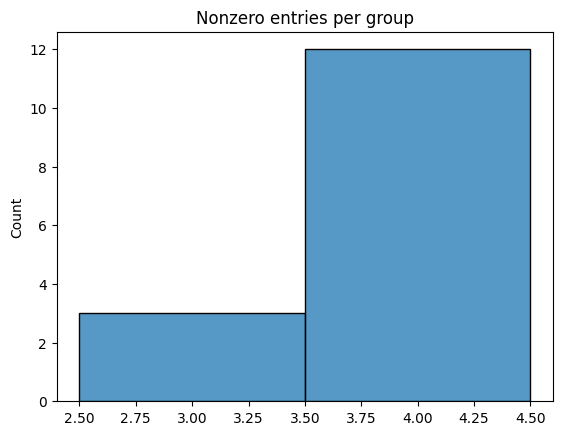

In [43]:
print("Solution sparsity (ratio of nonzero entries): ")

for k in np.arange(4):
    print(f"Instance {k}: ", sparsity(P.solution.precision_[k]))


stats = P.modelselect_stats.copy()
nnz,_,_ = consensus(P.solution.precision_, G)

fig, ax = plt.subplots()
sns.histplot(nnz, discrete = True, ax = ax)
#ax.set_yscale('log')
ax.set_title('Nonzero entries per group')

In [44]:
P.solution.precision_

{0: array([[ 1.20206261, -0.46983127,  0.03435263, -0.17901098, -0.        ,
          0.08763245],
        [-0.46983127,  1.31520657,  0.00627849,  0.04314549,  0.0912575 ,
         -0.40821175],
        [ 0.03435263,  0.00627849,  1.03808027, -0.06906024,  0.0605217 ,
         -0.16383474],
        [-0.17901098,  0.04314549, -0.06906024,  1.21998066, -0.18394825,
         -0.42263632],
        [-0.        ,  0.0912575 ,  0.0605217 , -0.18394825,  1.04115292,
         -0.03631633],
        [ 0.08763245, -0.40821175, -0.16383474, -0.42263632, -0.03631633,
          1.3126122 ]]),
 1: array([[ 2.26419095, -0.07539933, -1.24268191, -1.03829868, -2.74401239,
         -1.98679004],
        [-0.07539933,  1.04522268,  0.24966203,  0.04992364,  0.0861492 ,
          0.0101748 ],
        [-1.24268191,  0.24966203,  2.51099527,  1.2110421 ,  2.9307815 ,
          1.91897752],
        [-1.03829868,  0.04992364,  1.2110421 ,  1.72009989,  1.89004113,
          1.20315495],
        [-2.74401239, 

<Axes: >

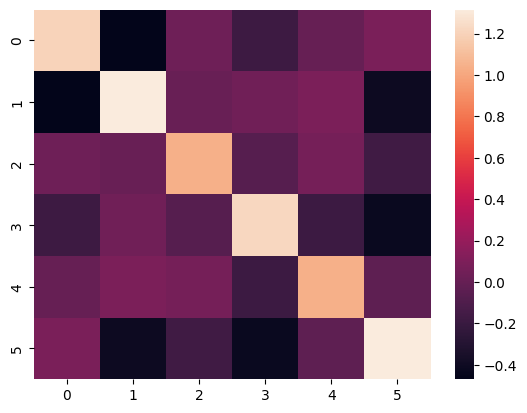

In [46]:
sns.heatmap(P.solution.precision_[0])

<Axes: >

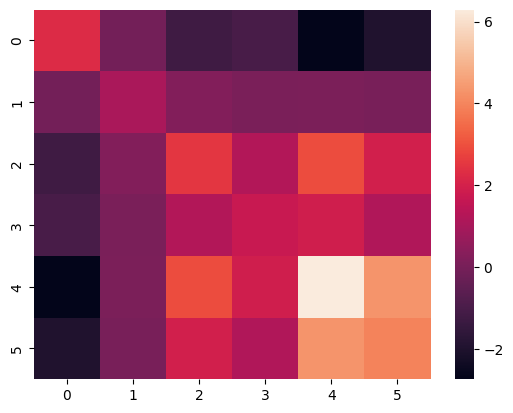

In [47]:
sns.heatmap(P.solution.precision_[1])